In [19]:
import scipy.io
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [8]:
TRAIN_EVAL_SPLIT = 700

In [9]:
mat_data = scipy.io.loadmat('Xtrain.mat')
data = pd.DataFrame(mat_data['Xtrain'])
training_data = data[:TRAIN_EVAL_SPLIT]

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [74]:
def create_dataset(data, time_step=100):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, 20)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [75]:
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(y_test.size)

294


In [81]:
# Build the stacked LSTM model
n_steps = X.shape[1]
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [76]:
from keras.layers import Bidirectional
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# Build the Bidirectional LSTM model
n_steps = X.shape[1]
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/lena/Library/CloudStorage/OneDrive-Personal/03_Uni/UU/Period 1.4/DeepLearning/DeepLearning/Interpreter/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [82]:
# Train the model
model.fit(X_train, y_train,  epochs=50, batch_size=32)

# Forecast future values
forecast = model.predict(X_test)
# Inverse transform to original scale
forecast = scaler.inverse_transform(forecast)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0592
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0421
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0413
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0381
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0352
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0320
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0230
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0190
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0154
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0160
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0159
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0153
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0152
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0119
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0155
Epoc

In [83]:
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, forecast)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 5195.297545253931
Root Mean Squared Error (RMSE): 72.07841247734255
Mean Absolute Error (MAE): 61.46349861050603


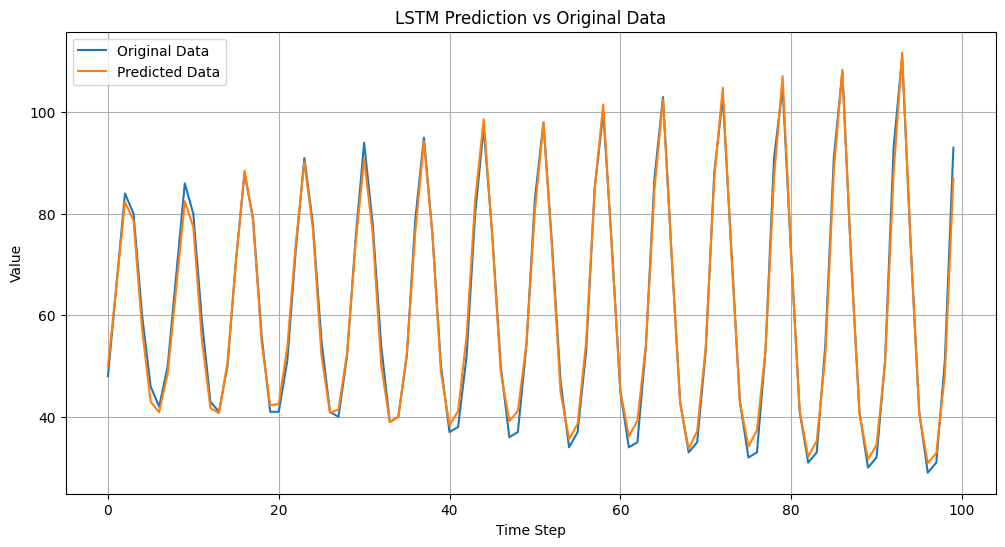

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1))[:100], label='Original Data')
plt.plot(forecast[:100], label='Predicted Data')
plt.title('LSTM Prediction vs Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()